In [1]:
seriesId = 'NHSDPCS' #FRED data series ID
apiKey = "c71c855489afb5327e992f3829276b54" #personal key, need to get one per app

import certifi
import urllib3
import json
import datetime

import pandas as pd
import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#get FRED series data and return data frame
def getFREDSeriesData (seriesId, apiKey): 
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    requestUrl = "https://api.stlouisfed.org/fred/series/observations?series_id=" + seriesId + "&api_key=" + apiKey + "&file_type=json"

    payload = http.request('GET', requestUrl)
    rawData = json.loads(payload.data.decode('utf-8'))
    df = pd.json_normalize(rawData['observations'])

    return df

In [3]:
#clean up FRED data
def cleanFREDSeriesData (df):
    df['value'] = pd.to_numeric(df['value']) * 1000 #convert data from thousands
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.sort_values('date', inplace=True)
    df.reset_index(inplace=True)
    df.set_index('date', inplace=True)
    df.drop(['realtime_start', 'realtime_end', 'index'],axis=1, inplace=True)

    return df

In [4]:
#date filter df
def dateFilterDF(df, startDate, endDate):
    df = df.loc[startDate:endDate]
    return df

In [5]:
#detrend specified column of df, return df with "detrendValue" column
def detrendColumn(df, column):
    df['detrendValue'] = detrend(df[column])
    return df

In [6]:
def logNormColumn (df, column):
    df['logNormValue'] = np.log(df[column])
    return df

In [7]:
def sarimaModel(data, forecastLength):
    # define model configuration
    order = (1, 1, 1)
    seasonalOrder = (1, 1, 1, 12)

    # define model
    model = SARIMAX(data, order=order, seasonal_order=seasonalOrder)

    # fit model
    model_fit = model.fit()

    # one step forecast
    return model_fit.forecast(forecastLength)

In [8]:
#get master FRED data
newHmSalesMaster = getFREDSeriesData(seriesId, apiKey) #get FRED new home sales
newHmSalesMaster = cleanFREDSeriesData(newHmSalesMaster) #cleanup FRED new home sales

In [9]:
#generate and norm validation data set
validationDataSet = dateFilterDF(newHmSalesMaster, '2015-01-01', '2015-12-01')
validationDataSet = detrendColumn(validationDataSet, 'value')

#calculate moving avg
movingAvg = validationDataSet['detrendValue'].rolling(2).mean()
movingAvg.dropna(inplace=True)

In [12]:
#generate and norm training data set
trainingDataSet = dateFilterDF(newHmSalesMaster, '1999-01-01', '2014-12-01')
trainingDataSet = detrendColumn(trainingDataSet, 'value')
forecastDataSet = sarimaModel(trainingDataSet['detrendValue'], 12)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


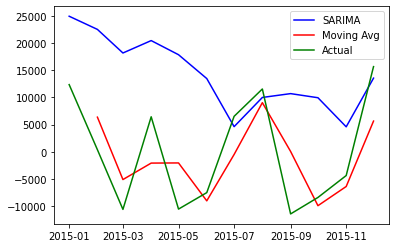

In [16]:
plt.plot(forecastDataSet, color='blue', label='SARIMA')
plt.plot(movingAvg, color='red', label='Moving Avg')
plt.plot(validationDataSet['detrendValue'],color='green', label='Actual')
plt.legend()